In [1]:
"""
Allow some options on the plots (zoom, resize, save),
/!\: have to wait to the end of the cell's execution
before launch the next
"""
%matplotlib notebook

# standard plot inside the netbook, but no options available
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists, basename
from scipy.io import wavfile
import pickle
import json
from pprint import pprint
from IPython.display import Audio, display, Markdown
import warnings
import sys
import pandas

import birdsonganalysis as bsa

# utils module from current folder
from utils import (boari_synth_song_error, draw_learning_curve,
                   carac_to_calculate_err_of_synth, err_per_feat)
from cmp_2_sim import plot_gesture_starts

# Allow to import the modules in the model folder
sys.path.append('../model/')
from measures import normalize_and_center, bsa_measure
from song_fitter import SongModel, get_scores
from synth import synthesize

sns.set_palette('colorblind')

fig_width = 16 # full screen: 16 / half screen: 10
fig_height = 5

2 options:
- results from 1 simulation (1 folder)
- results from a cluster: multiple simulations (1 folder with multiples sub-folders)

In [2]:
# path of the folder with the results
res_path = '../model/res/'

# -- 1 simulation --
# path = res_path + 'test_long_div_th_new_params_180920_145921'

# -- Cluster simulations : All parameters are defined at the same time --
cluster_sim_path = res_path + 'long_grid_div_th_180821_183837/'
param_name = "seed2+long_grid_div_th+3500_diversity_th"
path = cluster_sim_path + param_name

if exists(join(path, 'aborted.txt')):
    warnings.warn('Aborted run')
if not exists(join(path, 'data.pkl')):
    warnings.warn('Run is not finished')

In [3]:
# load the parameters used for the simulation
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)

try:
    with open(join(path, 'desc.md'), 'r') as f:
        display(Markdown( '> ' + '\n> '.join(f.read().split("\n"))))
except FileNotFoundError:
    try: 
        with open(join(cluster_sim_path, 'desc.md'), 'r') as f:
            display(Markdown( '> ' + '\n> '.join(f.read().split("\n"))))
    except NameError:
        print("1 simulation case: 'cluster_sim_path' is not defined and no desc for this run too." )
    except FileNotFoundError:
        print('No desc for this run.')

> # Run description
> 
> ## Goals
> 
> - Look for the effect of a longer simulation (from 30 days to 60 days)
> 	- Does the number of gestures keep increasing?
> - Add new deviation parameters
> 	- Hope to give better results while keeping the same dynamic as the precedent simulations
> 
> ## What have changed compared to previous runs?
> 
> - 5 seeds: 0 to 4
> - 60 days
> - div_th: 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
> - different deviation parameters (see default_dev from the dev_test configuration):
> 	- f_alpha_1: from 1 to 10
> 	- f_alpha_2: from 1 to 10
> 	- phase_alpha_3: from 0.005 to 0.05
> 	- b_beta: from 0.01 to 0.02
> 	- f_beta: from 1 to 10
> - mutation probabilities:
> 	- P(delete) = 0.1
> 	- P(split) = 0.1
> 	- P(move) = 0.75
> 	- P(nothing) = 0.05
> - Addition from long_grid_div_th_180823_234910:
> 	- 5 seeds: 5 to 9
> 	- div_th: 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
> - Addition from long_grid_div_th_180825_020723:
> 	- 10 seeds: 0 to 9
> 	- new div_th: 2750, 3250, 3750, 5500, 6000
> 
> ## Expected Results (Success condition)
> 
> -
> 
> <!-- ## Notes -->
> 

# Simulation parameters

In [4]:
out = '| key | value |\n|---|---|\n' 
out += '\n'.join(['| {} | {} |'.format(key, run_param[key]) for key in sorted(run_param.keys())])
display(Markdown(out))

| key | value |
|---|---|
| coefs | {'goodness': 1, 'pitch': 0, 'rms': 1, 'amplitude': 1, 'am': 1, 'fm': 1, 'entropy': 1} |
| comp | linalg |
| concurrent | 3 |
| days | 60 |
| dev | [0.1, 0.1, 0.05, 10, 0.05, 0.05, 0.05, 10, 0.001, 0.001, 0.05, 100, 0.2, 0.05, 0.02, 0.05, 10, 0.005] |
| diversity_threshold | 3500 |
| dlm | optimise_gesture_whole_local_search |
| iter_per_train | 20 |
| muta_proba | [0.1, 0.1, 0.75, 0.05] |
| name | seed2+long_grid_div_th+3500_diversity_th |
| night_concurrent | 20 |
| nlm | mutate_microbial_diversity_uniform |
| prior | [0, 0, 3.141592653589793, 15, 0, 0, 0.39269908169872414, 45, 0, 0, 0, 5000, 0, 0, 0, 0, 0, -0.15] |
| replay | 200 |
| seed | 2 |
| train_per_day | 200 |
| tutor | ../data/boari_short.wav |

# Get data

In [5]:
# -- Tutor --
sr, tutor = wavfile.read(join(path, 'tutor.wav'))
tutor = normalize_and_center(tutor)

# -- Songs learned --
outputs = []

try:
    with open(join(path, 'data.pkl'), 'rb') as f:
        songlog = pickle.load(f)
except FileNotFoundError:
    try:
        warnings.warn('Learning not over')
        with open(join(path, 'data_cur.pkl'), 'rb') as f:
            songlog = pickle.load(f)
    except FileNotFoundError:
        print("Error: no data files")
    
root_data = [item[1] for item in songlog if item[0] == 'root']
rd = pandas.DataFrame(root_data)

day_index = -1  # -1: last day

smodels = rd['songs'].iloc[day_index]
# outputs contains the different final songs
outputs = [smodel.gen_sound() for smodel in smodels]
# final best song
best = np.argmin(rd['scores'].iloc[day_index])
ab = smodels[best].gen_alphabeta()
song = smodels[best].gen_sound()

g_starts = []
for start, g in smodels[best].gestures:
    # store the starts timing
    g_starts.append(start)
    # Allow to split the gesture on the alpha and beta plots
    ab[start] = np.nan

# -- Boari's Synthesized song --
song_name = basename(run_param['tutor']).split('.')[0]
sr, synth_song = wavfile.read('../data/{}_out.wav'.format(song_name))
synth_ab = np.loadtxt('../data/{}_ab.dat'.format(song_name))
"""
add the missing samples to synth_ab because
The Boari's algorithm removes 612 samples by generating the synthesized song 
"""
pad0 = synth_ab[-1,0] * np.ones((612,1))
pad1 = synth_ab[-1,1] * np.ones((612,1))
pad = np.concatenate((pad0, pad1), axis=1)
synth_ab = np.concatenate((synth_ab, pad), axis=0)

# Boari's GTE detection
gtes = np.loadtxt('../data/{}_gte.dat'.format(basename(run_param['tutor']).split('.')[0]))

In [6]:
"""
For simulations which have saved data during the day and night algorithms
Did not had time to exploit it currently ...
"""
# nightlog = []
# with open(join(path, 'data_night.pkl'), 'rb') as f:
#     while True:
#         try:
#             nightlog.append(pickle.load(f))
#         except EOFError:
#             break
# daylog = []
# with open(join(path, 'data_day.pkl'), 'rb') as f:
#     while True:
#         try:
#             daylog.append(pickle.load(f))
#         except EOFError:
#             break
# print("len(daylog):", len(daylog))
# print("len(nightlog):", len(nightlog))

'\nFor simulations which have saved data during the day and night algorithms\nDid not had time to exploit it currently ...\n'

In [7]:
"""
Just for simulations using the day algorithm: optimise_proportional_training
"""
# day_data = [item[1] for item in songlog if item[0] == 'day' and item[1]['cond']=='define_number_of_trainings']
# dd = pandas.DataFrame(day_data)
# print(dd['train_per_day'])
# print(dd['train_per_day'].sum())

'\nJust for simulations using the day algorithm: optimise_proportional_training\n'

# Sound waves and spectral derivatives

/home/gnouveau/.virtualenvs/birdsong/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


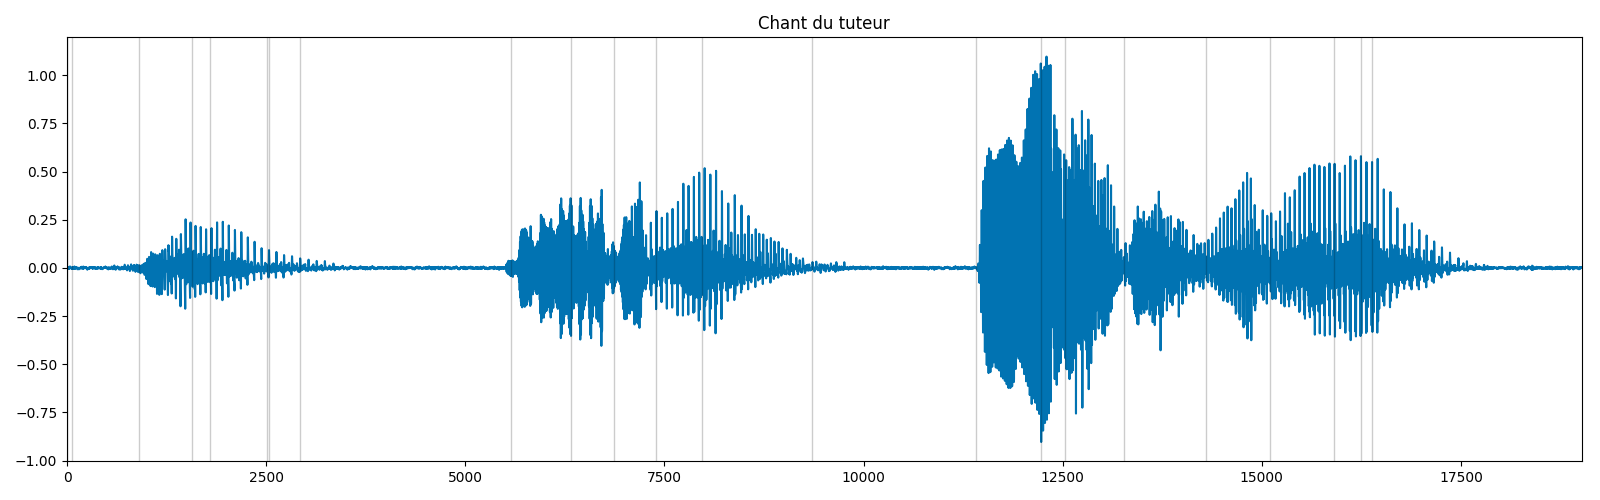

<IPython.core.display.Javascript object>


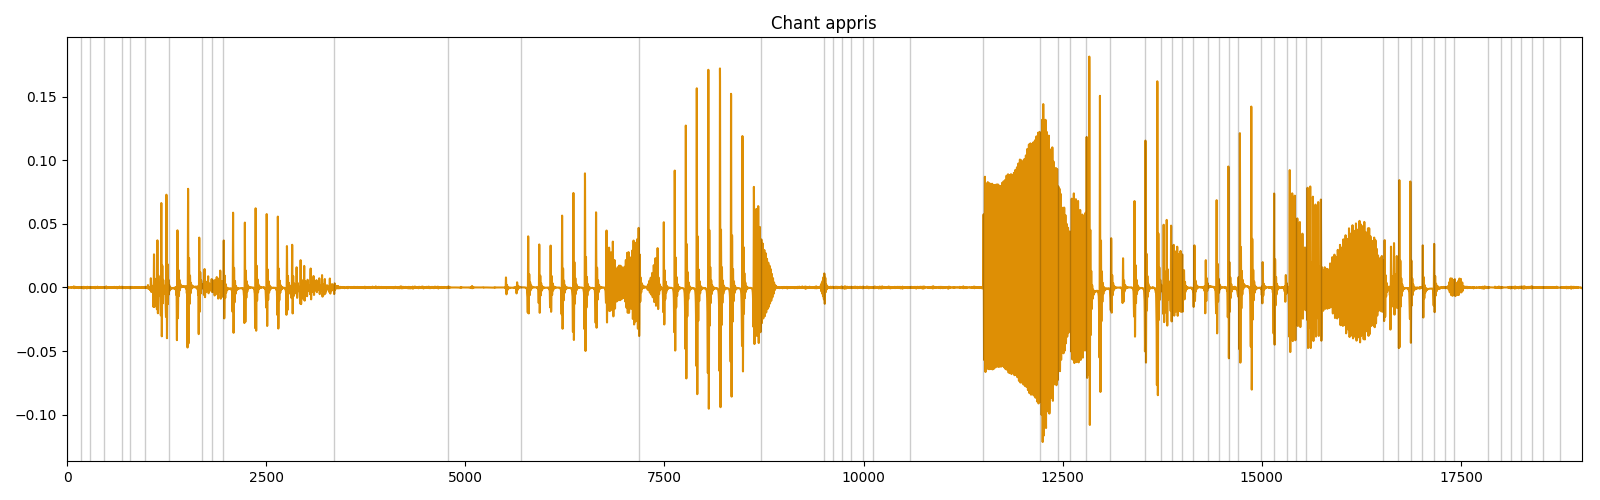

<IPython.core.display.Javascript object>


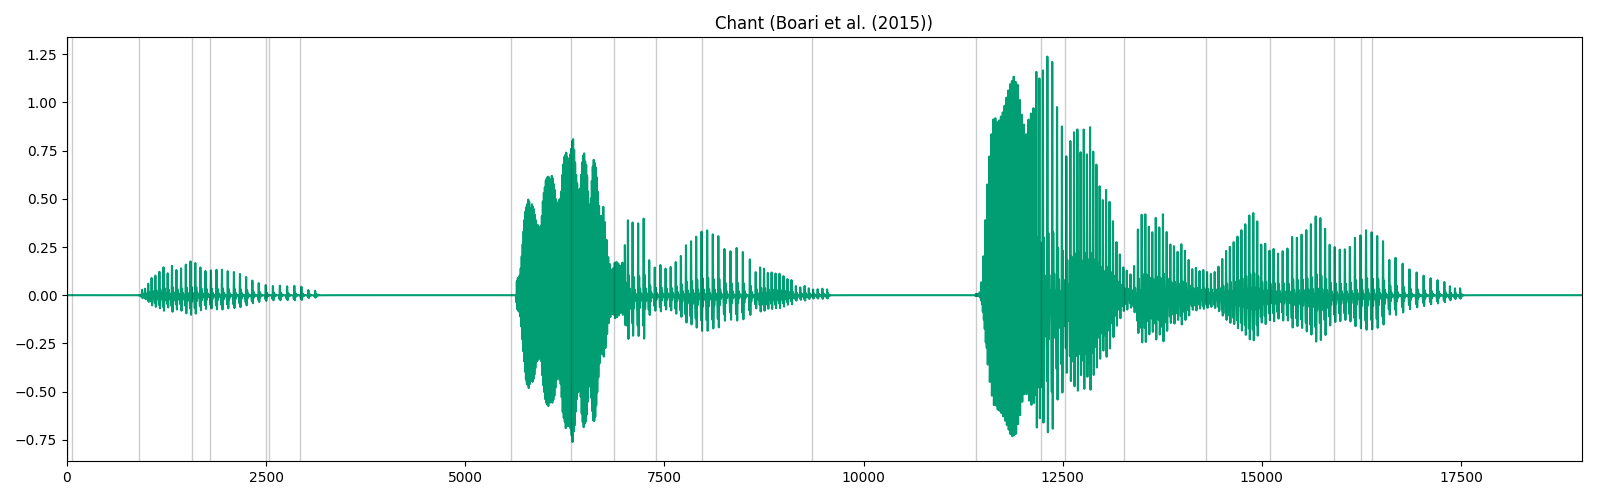

In [74]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(tutor)
plot_gesture_starts(gtes)
plt.xlim(0,len(tutor))
# x_ticks_loc = np.arange(0, 19000, 2500)
# x_ticks_label = (x_ticks_loc / bsa.SR).tolist()
# x_ticks_label = [round(elt, 3) for elt in x_ticks_label]
# plt.xticks(x_ticks_loc, x_ticks_label)
plt.title("Chant du tuteur")
plt.tight_layout()
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(song, color="C1")
plt.xlim(0,len(song))
plot_gesture_starts(g_starts)
plt.title("Chant appris")
plt.tight_layout()
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(synth_song, color="C2")
plot_gesture_starts(gtes)
plt.xlim(0,len(synth_song))
plt.title("Chant (Boari et al. (2015))")
plt.tight_layout()
plt.show()

In [9]:
# # Values specific to boari_short.wav
# starts = [500, 5300, 11300]
# ends = [4000, 10000, 18000]
# for i in range(len(starts)):
#     tutor_syll = tutor[starts[i]:ends[i]]
#     plt.figure(figsize=(fig_width, fig_height))
#     plt.plot(tutor_syll)
#     plot_gesture_starts(gtes - starts[i])
#     plt.xlim(0,len(tutor_syll))
#     plt.title("Tutor syllable #{}".format(i))
#     plt.show()
    
#     song_syll = song[starts[i]:ends[i]]
#     plt.figure(figsize=(fig_width, fig_height))
#     plt.plot(song_syll, color="C1")
#     plot_gesture_starts(np.array(g_starts) - starts[i])
#     plt.xlim(0,len(song_syll))
#     plt.title("Learned song syllable #{}".format(i))
#     plt.show()

<IPython.core.display.Javascript object>


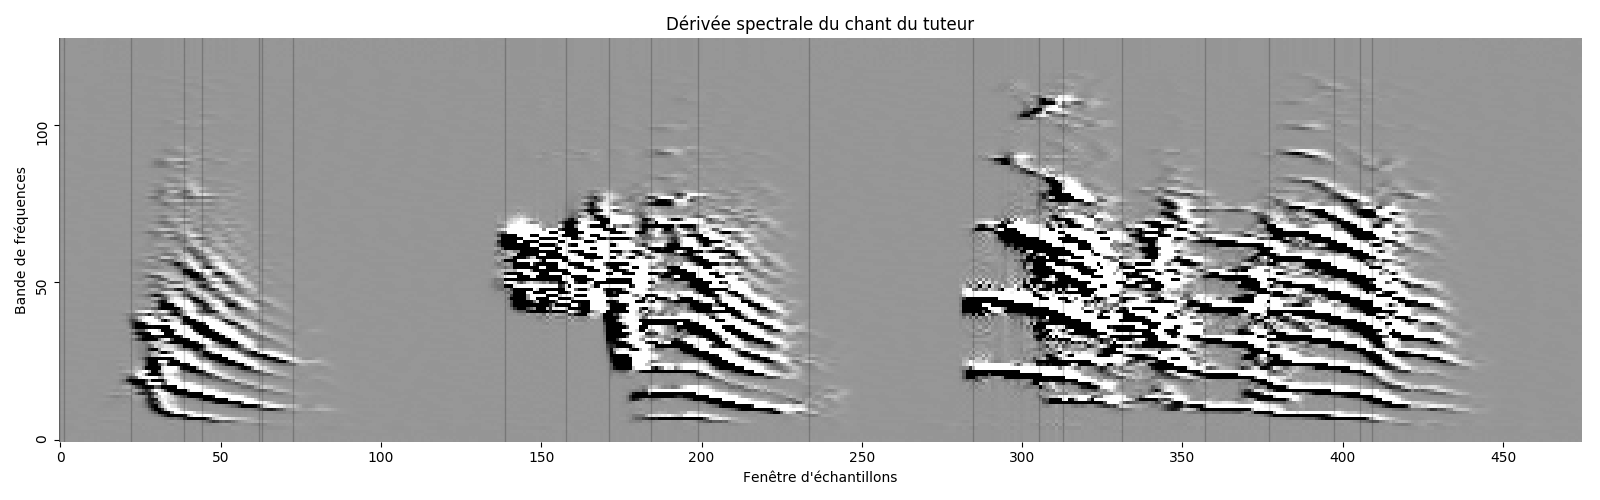

<IPython.core.display.Javascript object>


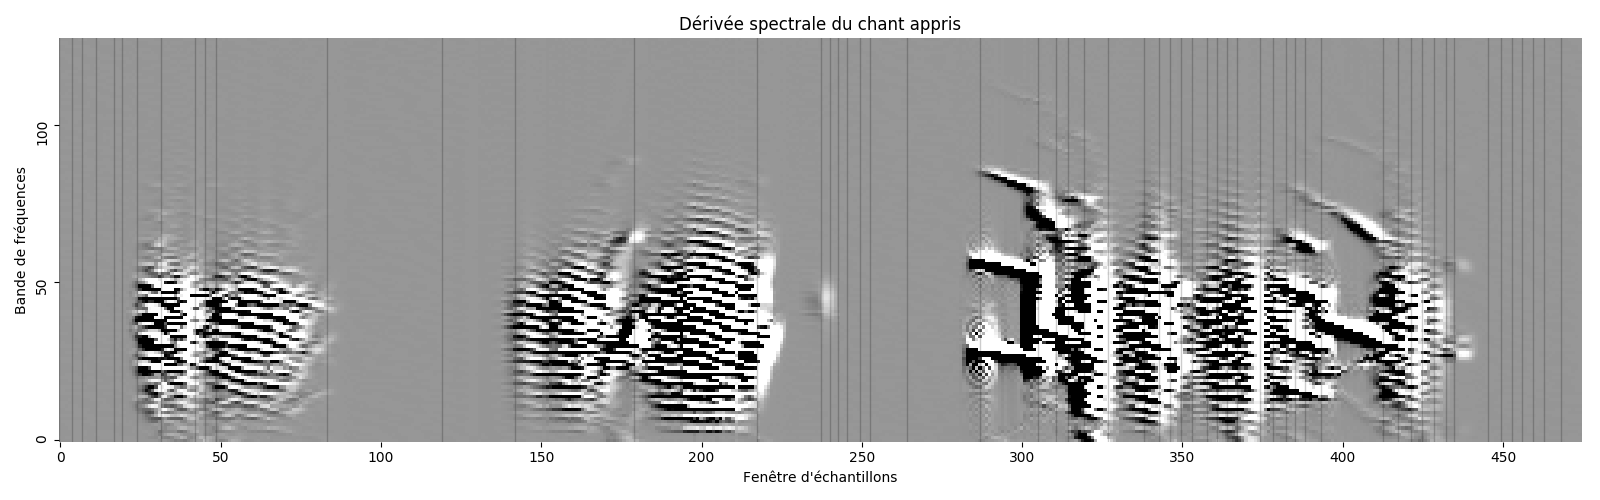

<IPython.core.display.Javascript object>


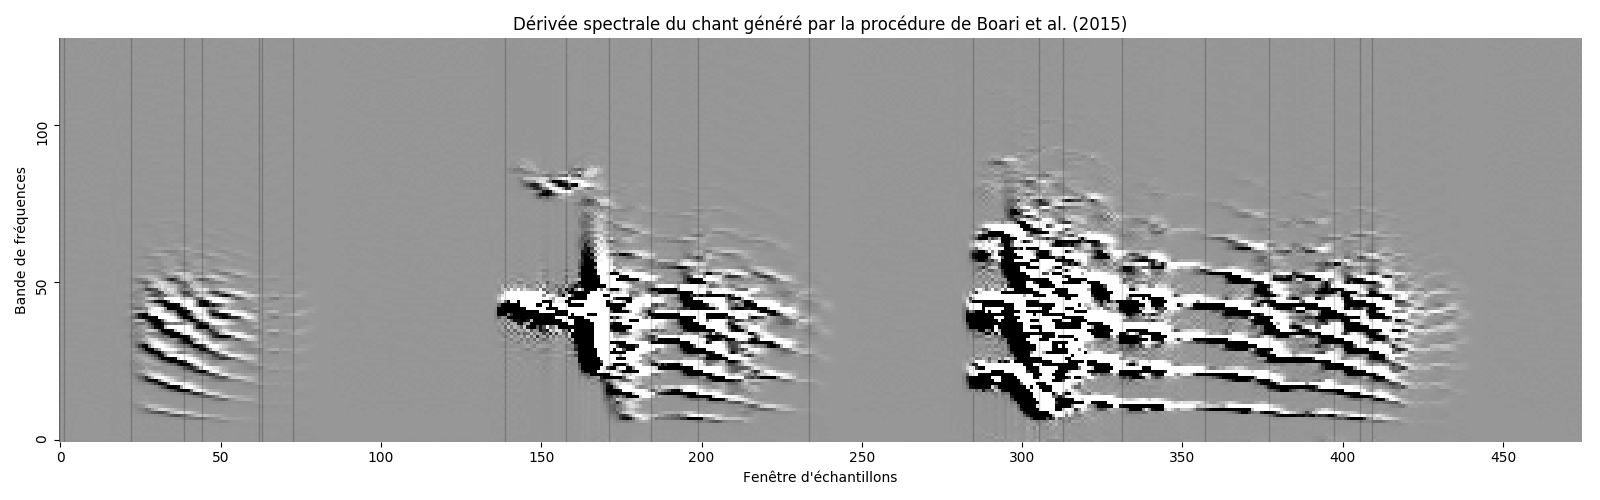

In [10]:
zoom = bsa.FFT_SIZE / bsa.FREQ_RANGE / 4

tutor_spec = bsa.spectral_derivs(tutor,
                                 bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE)
song_spec = bsa.spectral_derivs(song, 
                                bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE)
synth_spec = bsa.spectral_derivs(synth_song, 
                                 bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE)

# Spectral derivative of the tutor song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(tutor_spec, contrast=0.01, ax=ax,
                         freq_range=bsa.FREQ_RANGE)
# bsa.plot_over_spec(bsa.song_amplitude(tutor, 
#                                       bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE),
#                    ax=ax, zoom=zoom)
plot_gesture_starts(gtes, scale=bsa.FFT_STEP)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
ax.set_ylabel("Bande de fréquences")
ax.set_xlabel("Fenêtre d'échantillons")
# plt.title("spectral derivative of the tutor song")
plt.title("Dérivée spectrale du chant du tuteur")
fig.tight_layout()
plt.show(fig)

# Spectral derivative of the learned song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(song_spec, contrast=0.01, ax=ax)
# bsa.plot_over_spec(bsa.song_amplitude(song,
#                                       bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE),
#                    ax=ax, zoom=zoom)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
ax.set_ylabel("Bande de fréquences")
ax.set_xlabel("Fenêtre d'échantillons")
plot_gesture_starts(g_starts, scale=bsa.FFT_STEP)
# plt.title("spectral derivative of the learned song")
plt.title("Dérivée spectrale du chant appris")
fig.tight_layout()
plt.show(fig)

# Spectral derivative of the Boari's synthesized song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(synth_spec, contrast=0.01, ax=ax)
# bsa.plot_over_spec(bsa.song_amplitude(synth_song,
#                                       bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE),
#                    ax=ax, zoom=zoom)
plot_gesture_starts(gtes, scale=bsa.FFT_STEP)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
ax.set_ylabel("Bande de fréquences")
ax.set_xlabel("Fenêtre d'échantillons")
# plt.title("spectral derivative of the Boari's synthesized song")
plt.title("Dérivée spectrale du chant généré par la procédure de Boari et al. (2015)")
fig.tight_layout()
plt.show(fig)

# Sound

In [11]:
# Sound of the tutor song
display(Audio(tutor, rate=bsa.SR))

In [12]:
# Audio of the final songs
for output in outputs:
    display(Audio(output, rate=bsa.SR))

In [13]:
# Audio of the Boari's synth song
display(Audio(synth_song, rate=bsa.SR))

# Save learned song wav file

In [14]:
# normalize to get the sound louder
# wav_song = normalize_and_center(song)
# wavfile.write(filename="{}_song_bis.wav".format(param_name),
#               rate=bsa.SR,data=wav_song)

# Get features

In [15]:
# -- Initial tutor features: --
# used as parameter to rescale the others features
tfeat= bsa.all_song_features(tutor, bsa.SR,
                             freq_range=bsa.FREQ_RANGE,
                             fft_step=bsa.FFT_STEP,
                             fft_size=bsa.FFT_SIZE)

# -- Tutor features --
tutor_feat = bsa.rescaling_with_tutor_values(tfeat, tfeat)

# -- Learned song features --
sfeat = bsa.all_song_features(song, bsa.SR,
                              freq_range=bsa.FREQ_RANGE,
                              fft_step=bsa.FFT_STEP,
                              fft_size=bsa.FFT_SIZE)
song_feat = bsa.rescaling_with_tutor_values(tfeat, sfeat)

# -- Boari's synth song features --
syfeat = bsa.all_song_features(synth_song, bsa.SR,
                               freq_range=bsa.FREQ_RANGE,
                               fft_step=bsa.FFT_STEP,
                               fft_size=bsa.FFT_SIZE)
synth_feat = bsa.rescaling_with_tutor_values(tfeat, syfeat)

# Features comparison

<IPython.core.display.Javascript object>


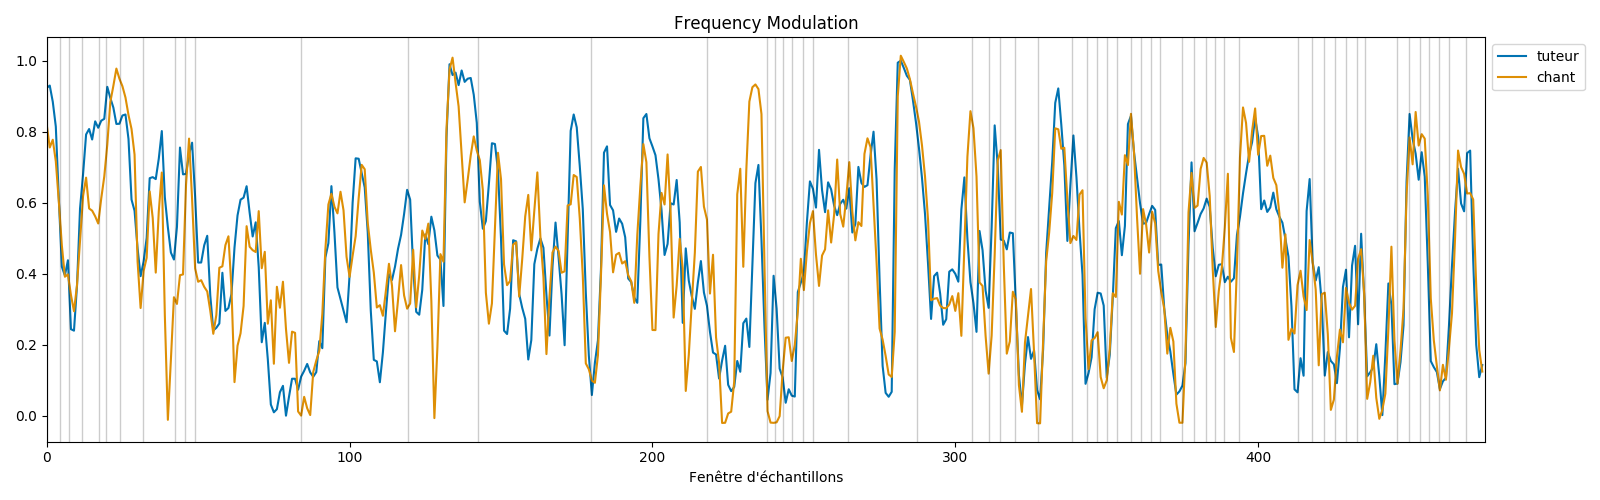

<IPython.core.display.Javascript object>


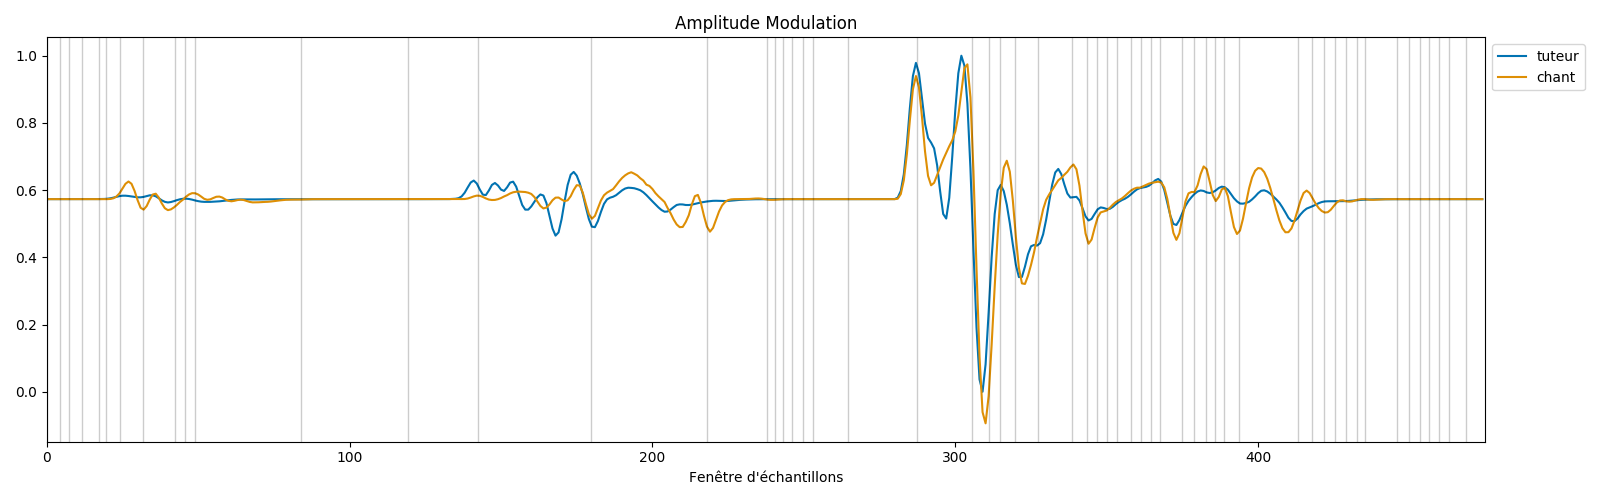

<IPython.core.display.Javascript object>


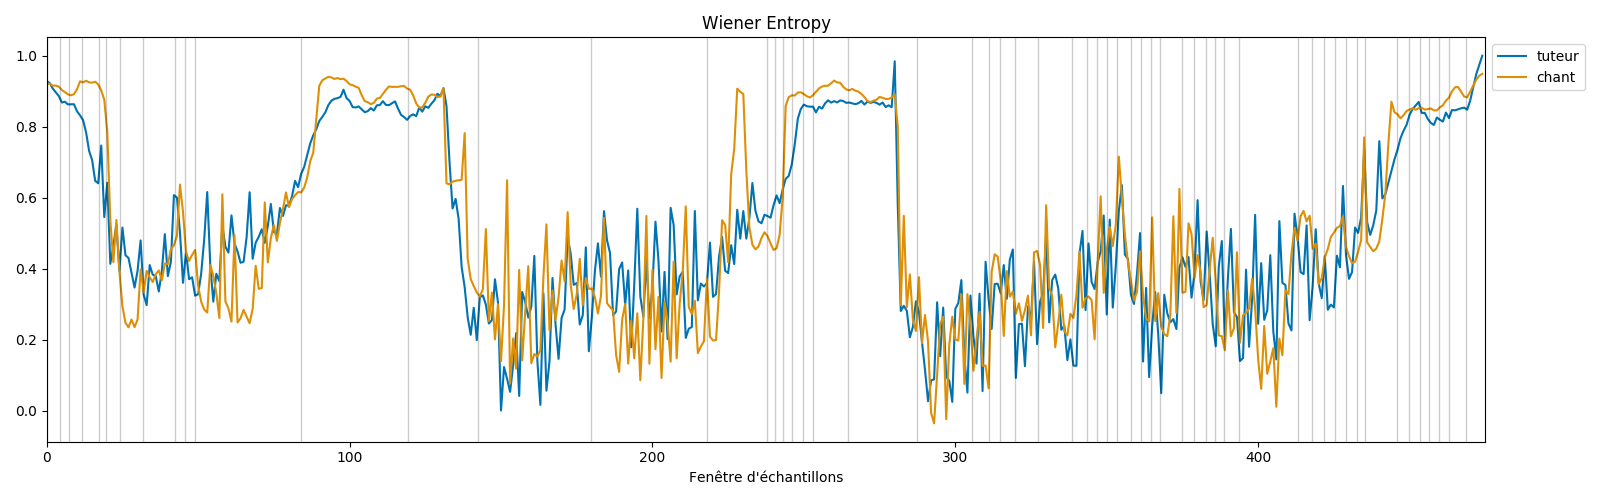

<IPython.core.display.Javascript object>


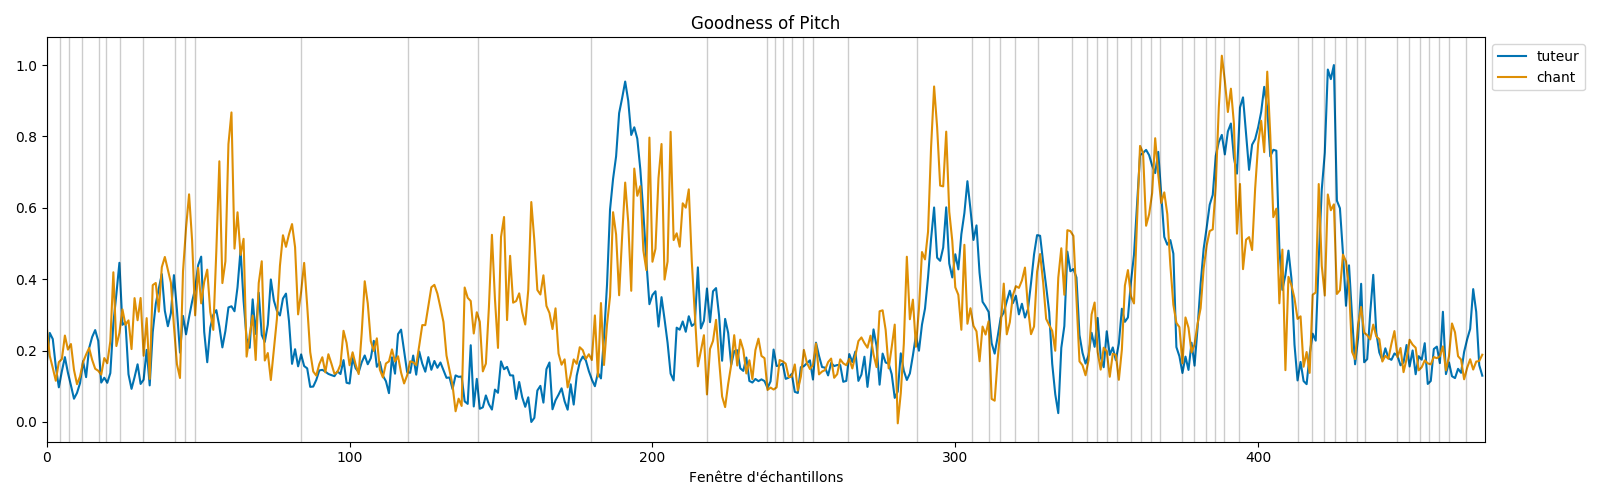

<IPython.core.display.Javascript object>


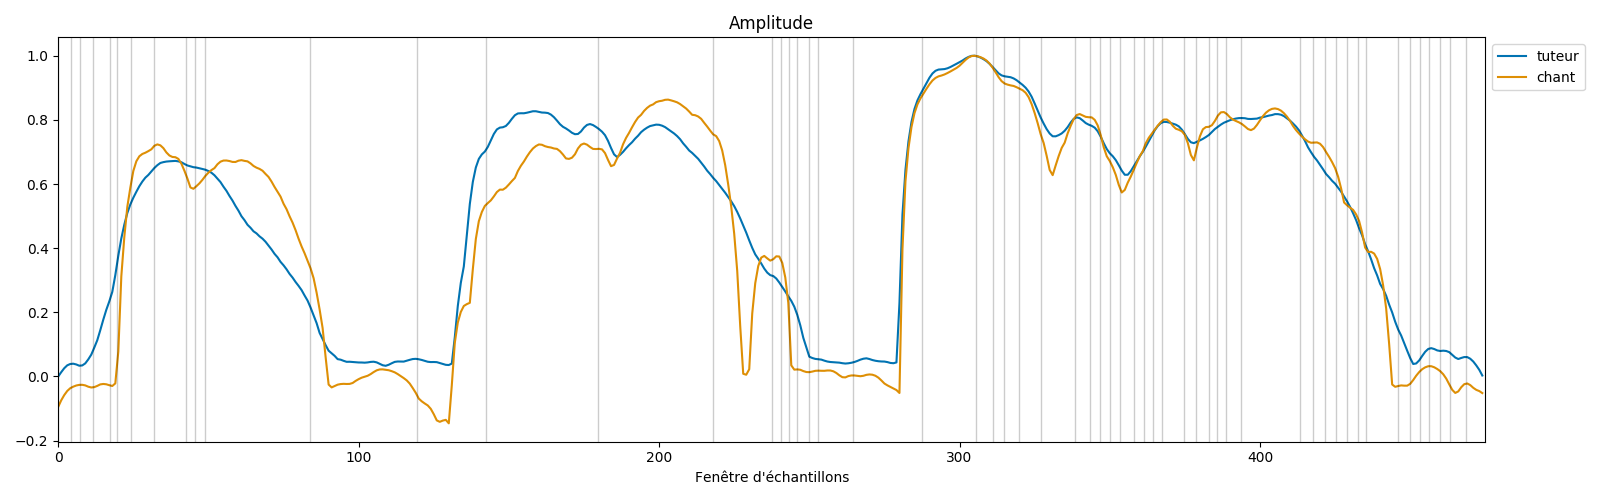

<IPython.core.display.Javascript object>


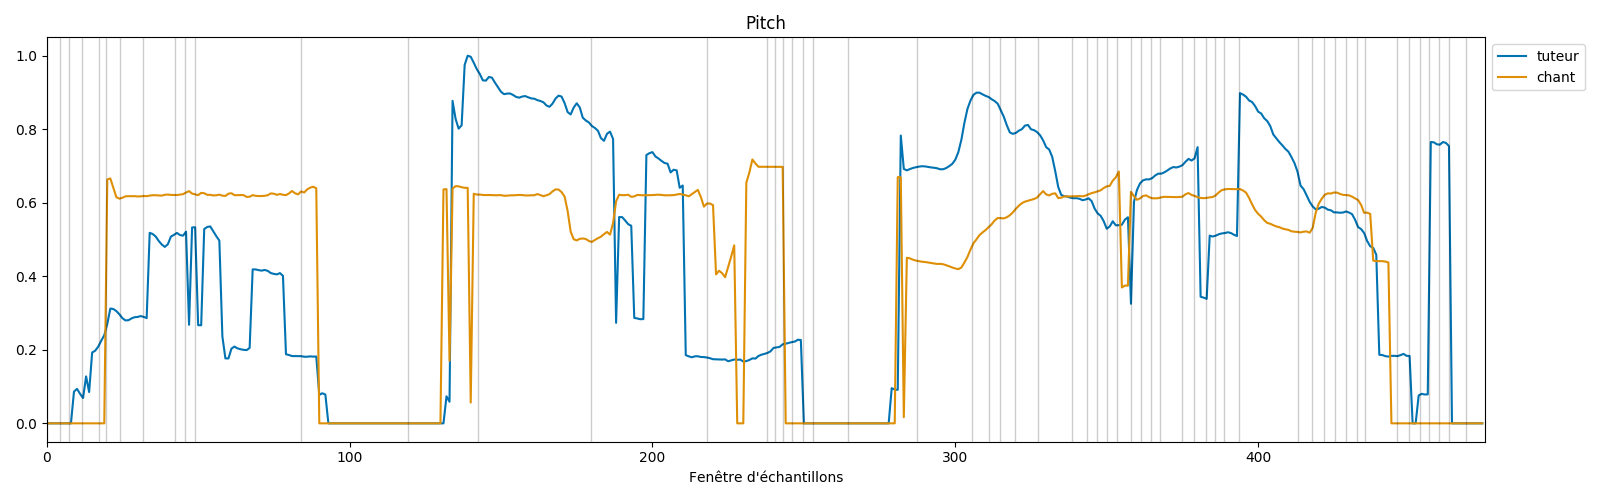

<IPython.core.display.Javascript object>


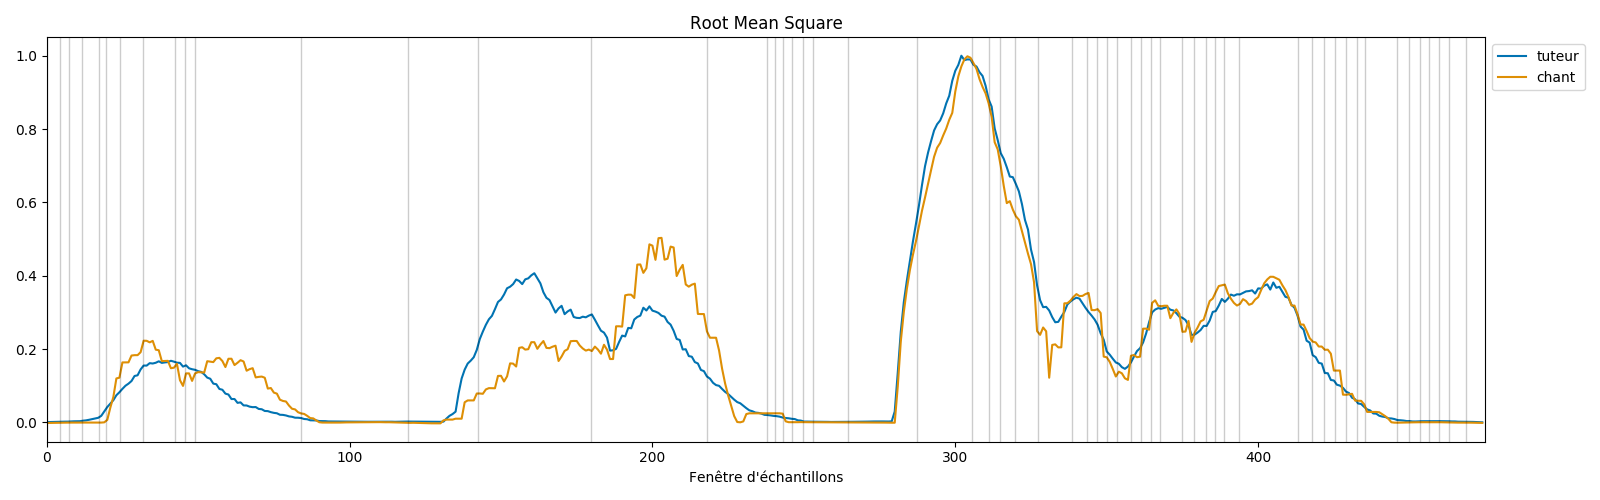

In [16]:
# Retrieve the threshold to plot it
amp, th = carac_to_calculate_err_of_synth(synth_song,
                                          tfeat["amplitude"])

fnames = ['fm', 'am', 'entropy', 'goodness', 'amplitude', 'pitch', 'rms']
titles = ["Frequency Modulation", "Amplitude Modulation", "Wiener Entropy",
          "Goodness of Pitch", "Amplitude", "Pitch", "Root Mean Square"]
for fname in fnames:
    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(tutor_feat[fname], label="tuteur")
    plt.plot(song_feat[fname], label="chant")
#     plt.plot(synth_feat[fname], alpha=0.2, label="synth")
    plot_gesture_starts(g_starts, scale=40)
    plt.xlim(0, len(tutor_feat[fname]))
    plt.xlabel("Fenêtre d'échantillons")
#     if fname == 'amplitude':
#         plt.axhline(y=th, color="k",
#                     linewidth=1, alpha=0.2, label="threshold")
    plt.title(titles[fnames.index(fname)])
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.tight_layout()
    plt.show()

coefficients: {'goodness': 1, 'pitch': 0, 'rms': 1, 'amplitude': 1, 'am': 1, 'fm': 1, 'entropy': 1}
Boari's score on boari_short.wav : 14.989055730662681
Best song model score: 6.686594607321918


<IPython.core.display.Javascript object>


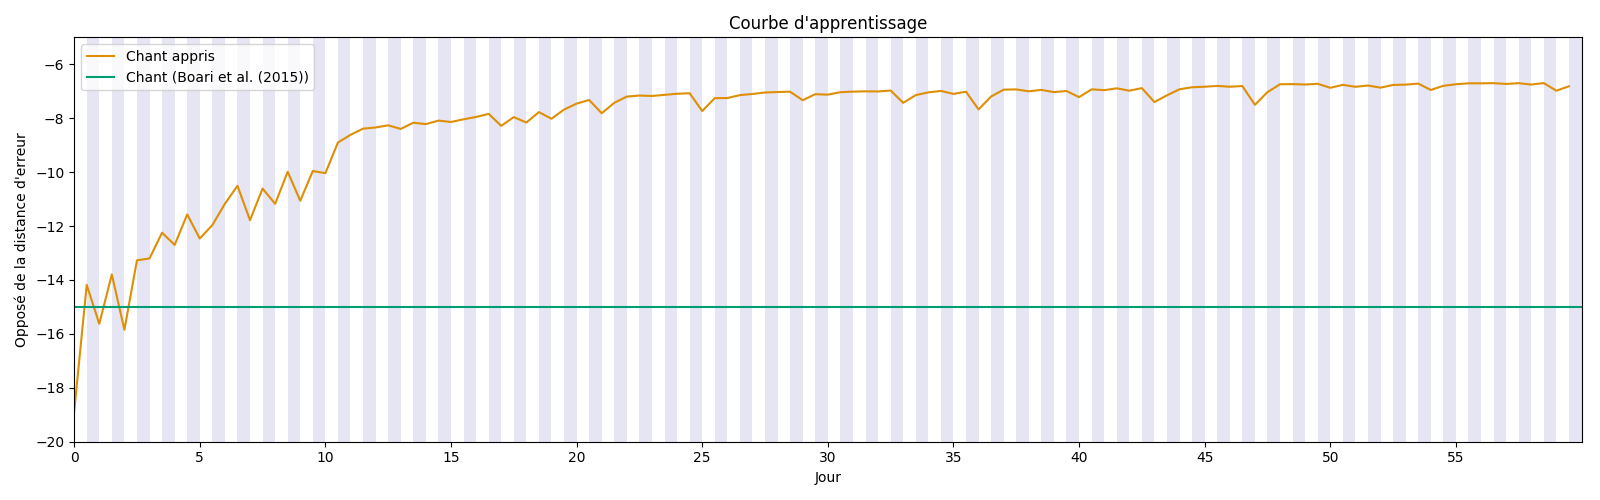

In [17]:
# /!\: if tutor_feat parameter is defined,
# use rescaling to calculate the error
score = boari_synth_song_error(tutor,
                               synth_song,
                               run_param['coefs'],
                               tutor_feat=tfeat)

best_score = rd['scores'].iloc[day_index][best]
print("coefficients: {}".format(run_param['coefs']))
print("Boari's score on {}.wav : {}".format(song_name, score))
print("Best song model score: {}".format(best_score))

# Plot
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
ax = draw_learning_curve(rd, ax=ax)
ax.axhline(y=-1 * score, color='C2', linestyle='-',
           label="Chant (Boari et al. (2015))")
# ax.set_yscale('log')
ax.legend()
plt.tight_layout()
plt.show(fig)

In [18]:
print("first scores: {}".format(rd['scores'].iloc[0]))
print("last scores: {}".format(rd['scores'].iloc[day_index]))
print("the best song index: {}".format(best))

first scores: [18.89435907 18.89435907 18.89435907]
last scores: [6.68659461 6.75156436 7.00722988]
the best song index: 0


In [19]:
mean_score = np.mean(rd['scores'].iloc[day_index])
print("mean score score at index {}: {}".format(day_index, mean_score))

mean score score at index -1: 6.8151296161978605


# Gesture analysis

The 18 parameter values of alpha and beta, for all the gestures

In [20]:
# print([round(elt, 2) for elt in run_param['prior'][:4]])
# print([round(elt, 2) for elt in run_param['prior'][4:8]])
# print([round(elt, 2) for elt in run_param['prior'][8:12]])
# print(run_param['prior'][13])
# print([round(elt, 2) for elt in run_param['prior'][13:]])
# print()
# print()

# np.set_printoptions(suppress=True,
#                     formatter={'float_kind':'{:0.2f}'.format})

# for gesture in smodels[best].gestures:
#     print("start: {}".format(gesture[0]))
#     str_alpha = str(gesture[1][:4])
#     str_alpha += '\n'+str(gesture[1][4:8])
#     str_alpha += '\n'+str(gesture[1][8:12])
#     str_alpha += '\n'+'['+str(round(gesture[1][12], 2))+']'
#     str_beta = str(gesture[1][13:])
#     print("parameters:\n{}\n{}".format(str_alpha, str_beta))

# # Come back to default values
# np.set_printoptions(suppress=None,
#                 formatter=None)

<IPython.core.display.Javascript object>


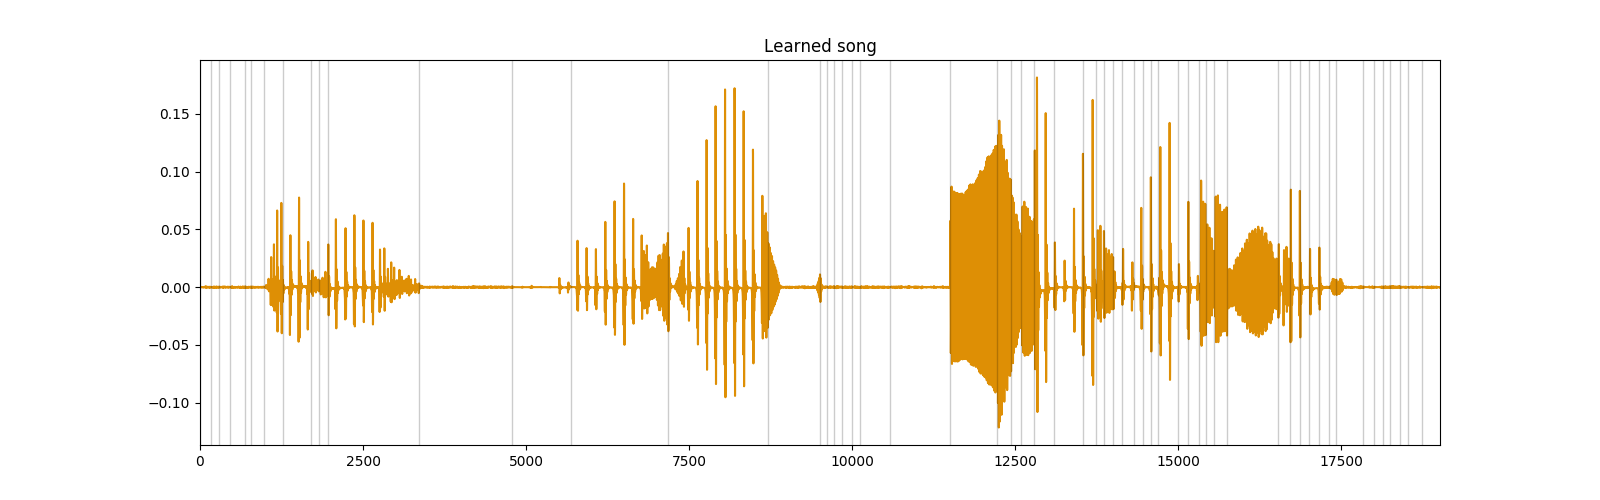

<IPython.core.display.Javascript object>


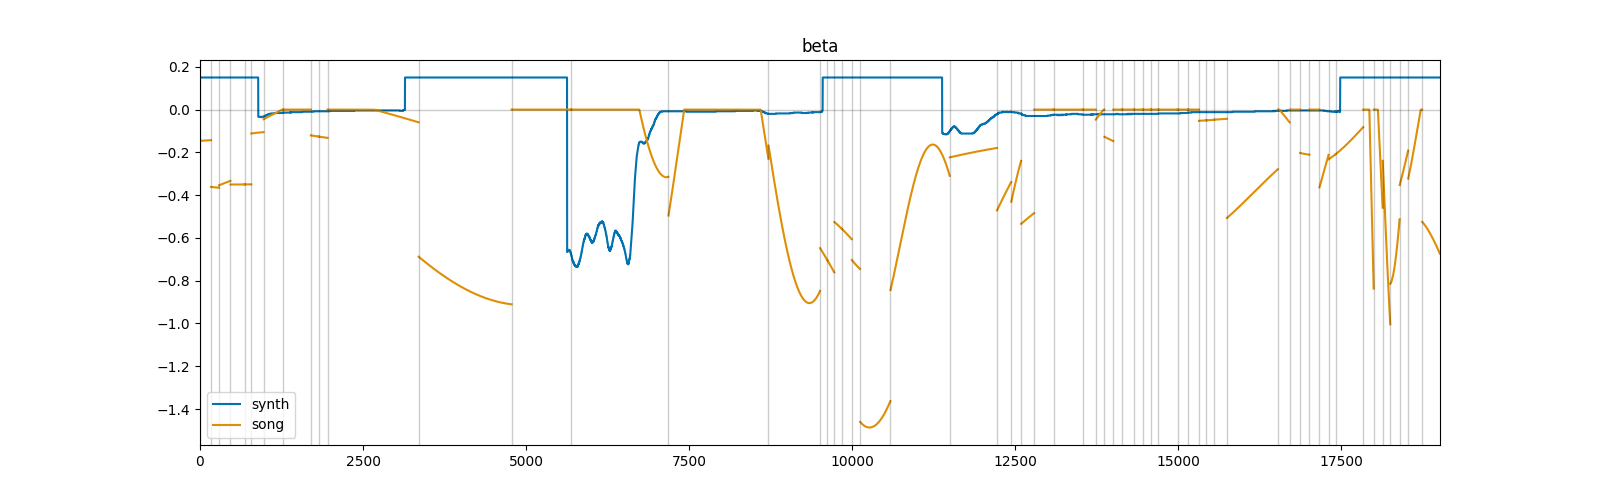

<IPython.core.display.Javascript object>


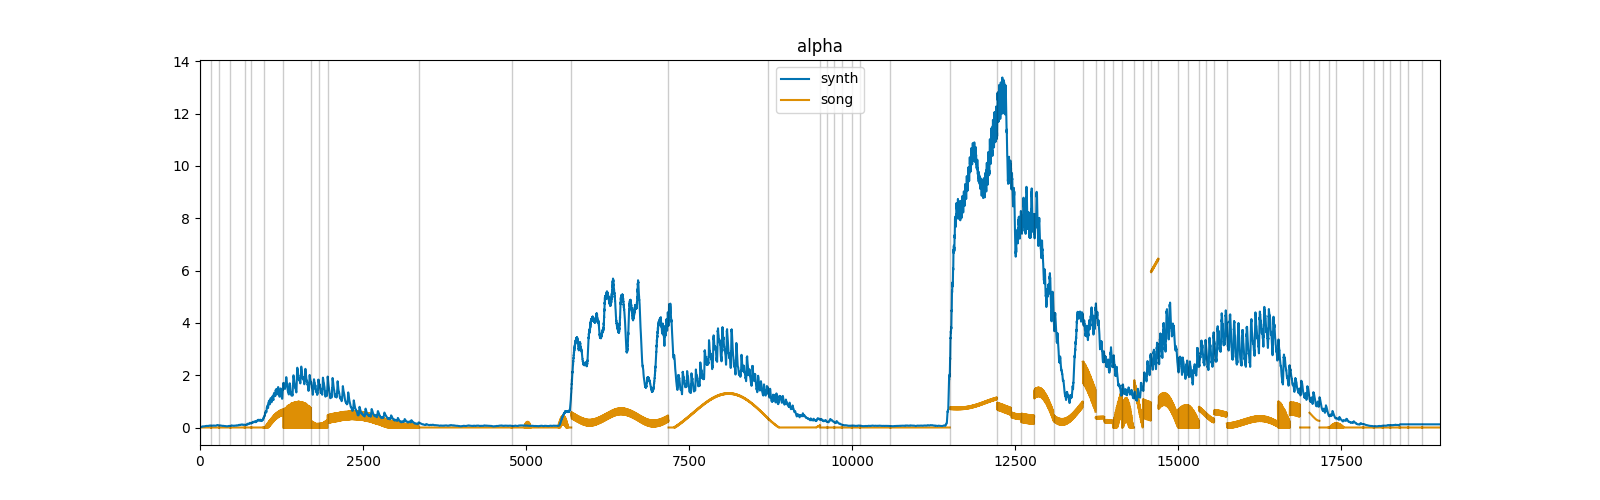

In [21]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(song, color='C1')
plt.xlim(0, len(song))
plot_gesture_starts(g_starts)
plt.title("Learned song")
plt.show()

# Comparison between learnt beta and tutor's beta
plt.figure(figsize=(fig_width, fig_height))
plt.plot(synth_ab[:, 1], label="synth")
plt.plot(ab[:, 1], label="song")
plt.axhline(y=0, color="k", linewidth=1, alpha=0.2)
plt.xlim(0, ab.shape[0])
plot_gesture_starts(g_starts)
plt.legend()
plt.title("beta")
plt.show()

# Normalization for easier comparison between learnt alpha and tutor's alpha
a_t = (synth_ab[:, 0] - np.min(synth_ab[:, 0])) / (np.max(synth_ab[:, 0]) - np.min(synth_ab[:, 0]))
a_s = (ab[:,0] - np.nanmin(ab[:,0])) / (np.nanmax(ab[:,0]) - np.nanmin(ab[:,0]))

fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
plt.title("alpha")
# Inversion of the plotting order
# -- normalized
# line1, = plt.plot(a_s, label="song", color="C1")
# line2, = plt.plot(a_t, label="synth", color="C0")
# -- not normalized --
line1, = plt.plot(ab[:,0], label="song", color="C1")
line2, = plt.plot(synth_ab[:, 0], label="synth", color="C0")
ax.legend((line2, line1), ("synth", "song"))
plt.xlim(0, ab.shape[0])
plot_gesture_starts(g_starts)
plt.show()

### tests à la volée

start: 1956
parameters:
[-0.74051734 -1.63504363  4.32800092 -1.99687875]
[-0.59720891  0.15255635 12.05864988 30.65453608]
[ 2.12175964e-02 -1.58028170e-01  1.37821720e+03  4.93084896e+03]
[-1.11]
[-0.68057413 -0.84080793 -0.43820897  0.79415342 -0.29778367]
(1396, 2)


/home/gnouveau/.virtualenvs/birdsong/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


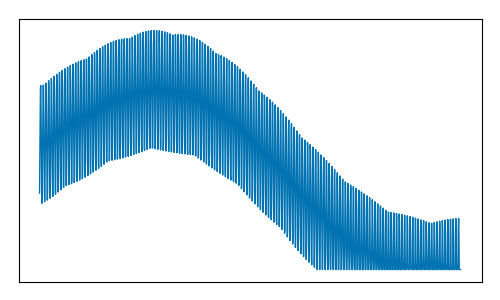

<IPython.core.display.Javascript object>


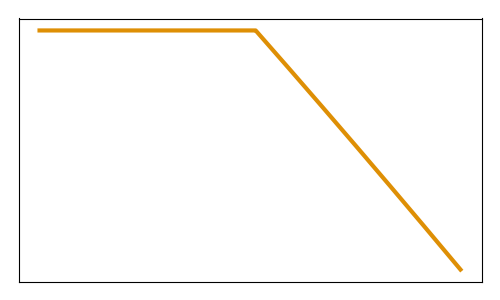

In [49]:
# np.set_printoptions(suppress=True,
#                     formatter={'float_kind':'{:0.2f}'.format})

# -- from the beginning --
index_gest = 10
# -- from the end --
# index_gest = len(smodels[best].gestures) - 10

l_gestures = []
l_gestures.append(smodels[best].gestures[index_gest])
for gesture in l_gestures:
    print("start: {}".format(gesture[0]))
    str_alpha = str(gesture[1][:4])
    str_alpha += '\n'+str(gesture[1][4:8])
    str_alpha += '\n'+str(gesture[1][8:12])
    str_alpha += '\n'+'['+str(round(gesture[1][12], 2))+']'
    str_beta = str(gesture[1][13:])
    print("parameters:\n{}\n{}".format(str_alpha, str_beta))

# Come back to default values
np.set_printoptions(suppress=None,
                formatter=None)

syl = smodels[best].gen_alphabeta(range_=[index_gest])
print(syl.shape)
# alpha
fig = plt.figure(figsize=(5, 3))
ax = plt.gca()
plt.plot(syl[:,0], color='C0', linewidth = 1)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.tight_layout()
plt.show()
# beta
fig = plt.figure(figsize=(5, 3))
ax = plt.gca()
plt.plot(syl[:,1], color='C1', linewidth = 3)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.tight_layout()
plt.show()

###  Evolution of the number of gestures

Mean number of gestures per day:
[10, 11, 12, 16, 17, 16, 20, 19, 17, 16, 21, 23, 26, 28, 27, 30, 34, 35, 36, 37, 34, 36, 37, 38, 38, 40, 42, 42, 43, 44, 45, 47, 47, 49, 49, 48, 48, 47, 49, 49, 49, 49, 50, 50, 51, 53, 54, 55, 55, 56, 57, 56, 56, 58, 57, 58, 59, 58, 58, 58]


<IPython.core.display.Javascript object>


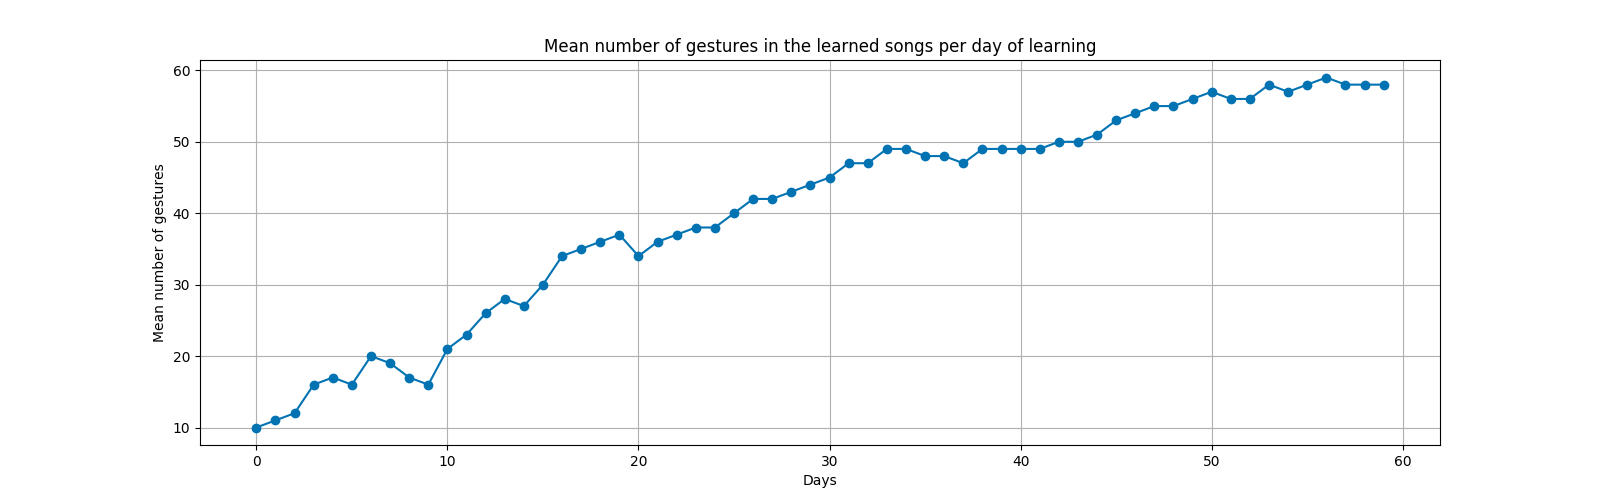

In [23]:
l_mean_nb_gest = []
for i in range(len(rd)):
    if i % 2 == 0: # Start of a day
        sum_nb_gest = 0
        for sm in rd['songs'].iloc[i]:
            sum_nb_gest += len(sm.gestures)
        l_mean_nb_gest.append(int(sum_nb_gest / len(rd['songs'].iloc[i])))
        
print("Mean number of gestures per day:")
print(l_mean_nb_gest)

fig = plt.figure(figsize=(fig_width, fig_height))
plt.plot(np.arange(len(rd)/2), l_mean_nb_gest, marker='o')
plt.grid()
plt.xlabel("Days")
plt.ylabel("Mean number of gestures")
plt.title("Mean number of gestures in the learned songs per day of learning")
plt.show()

In [24]:
# number of gestures in a learnt song
print("index of the best song:", best)
print(len(smodels[best].gestures))

index of the best song: 0
58


In [25]:
mean_gesture_nb = 0
for s in smodels:
    print(len(s.gestures))
    mean_gesture_nb += len(s.gestures)
    
mean_gesture_nb /= len(smodels)

print("mean number of gesture: {}".format(mean_gesture_nb))

58
58
58
mean number of gesture: 58.0


In [26]:
# numbers of gtes in the tutor song
gtes = np.loadtxt('../data/{}_gte.dat'.format(song_name))
true_gtes = gtes[np.concatenate(((np.diff(gtes) > 100), (False,)))]
print(len(gtes))
print(len(true_gtes))

24
20


# Alpha - Beta of songs

<IPython.core.display.Javascript object>


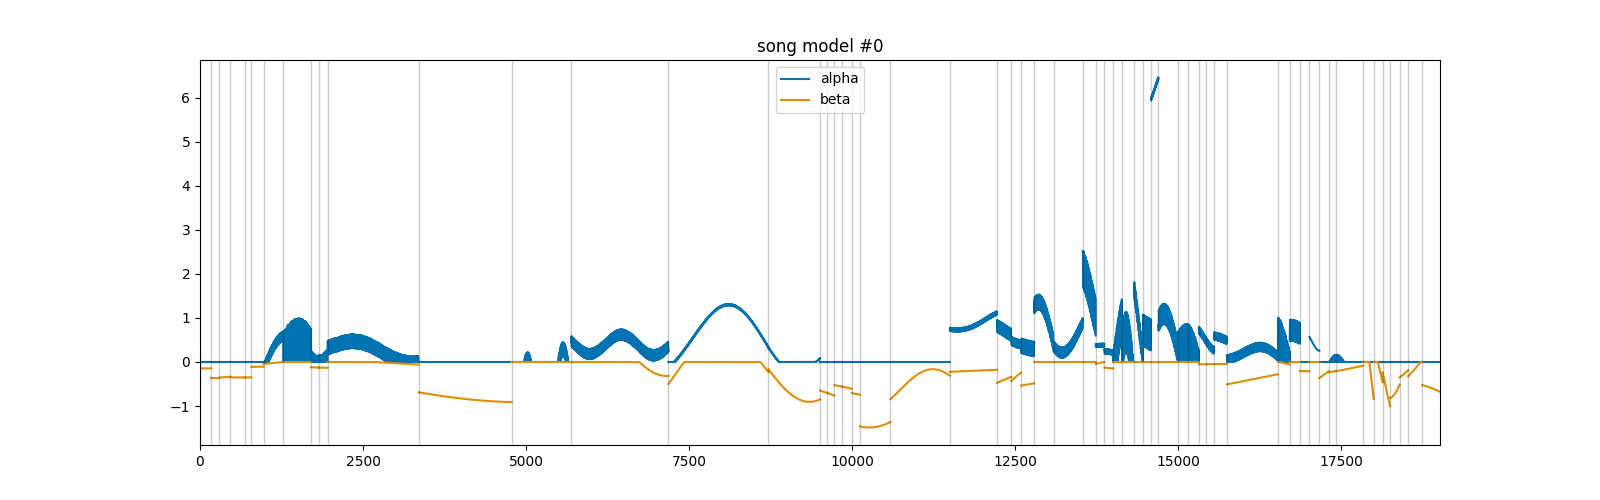

<IPython.core.display.Javascript object>


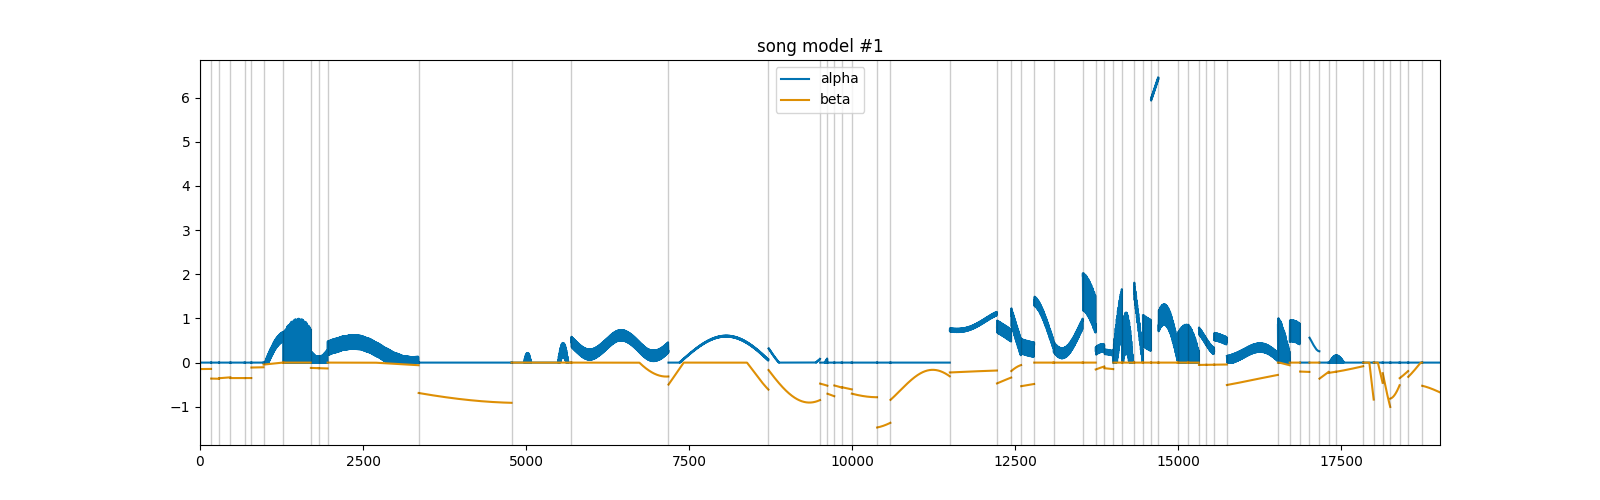

/home/gnouveau/.virtualenvs/birdsong/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


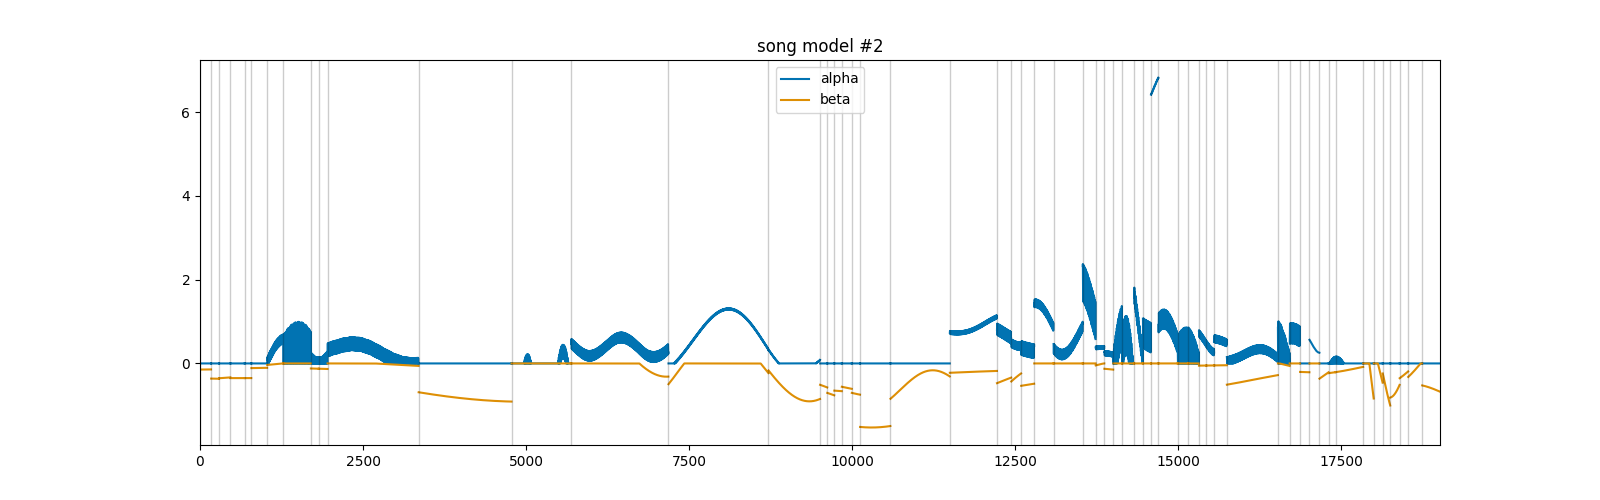

<IPython.core.display.Javascript object>


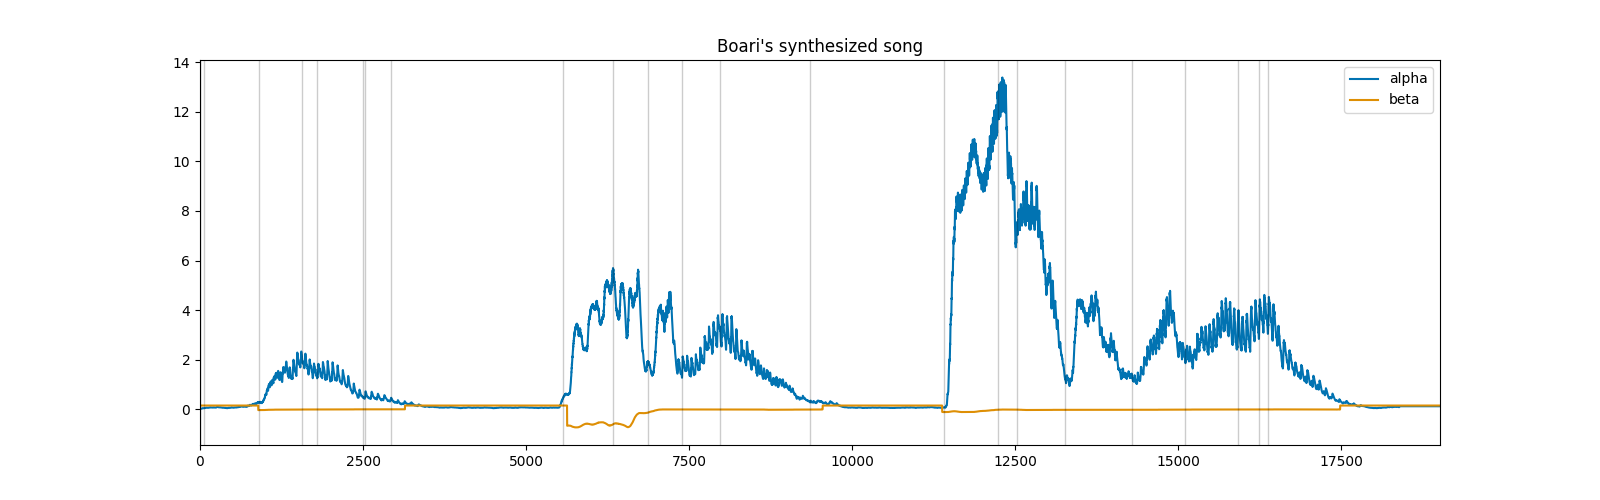

In [27]:
# plot the (alpha, beta) for the final songs and 
# the (alpha, beta) of the tutor's song with the GTEs
for i in range(len(rd['songs'].iloc[day_index])):
    plt.figure(figsize=(fig_width, fig_height))
    ab_tmp = rd['songs'].iloc[day_index][i].gen_alphabeta()
    # Allow to split the gesture on the alpha and beta plots
    for start, g in rd['songs'].iloc[day_index][i].gestures:
        ab_tmp[start] = np.nan
    plt.plot(ab_tmp[:, 0], label="alpha")
    plt.plot(ab_tmp[:, 1], label="beta")
    plt.xlim((0, ab_tmp.shape[0]))
    #plt.yticks([], [])
    for gesture in rd['songs'].iloc[day_index][i].gestures:
        start = gesture[0]
        plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
    plt.title("song model #{}".format(i))
    plt.legend()

# Tutor song + gtes of the best optimised song
plt.figure(figsize=(fig_width,fig_height))
plt.plot(synth_ab[:,0], label="alpha")
plt.plot(synth_ab[:,1], label="beta")
plt.xlim((0, ab.shape[0]))
for gesture in gtes:
    start = gesture
    plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
plt.title("Boari's synthesized song")
plt.legend()
plt.show()

# Calculation of each feature error

threshold: -1.0192144792730786
err_feat_vect:  [14.38208832  0.97232117  8.70850165 13.12561438  5.03172298  0.
  2.49029894]


/home/gnouveau/.virtualenvs/birdsong/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


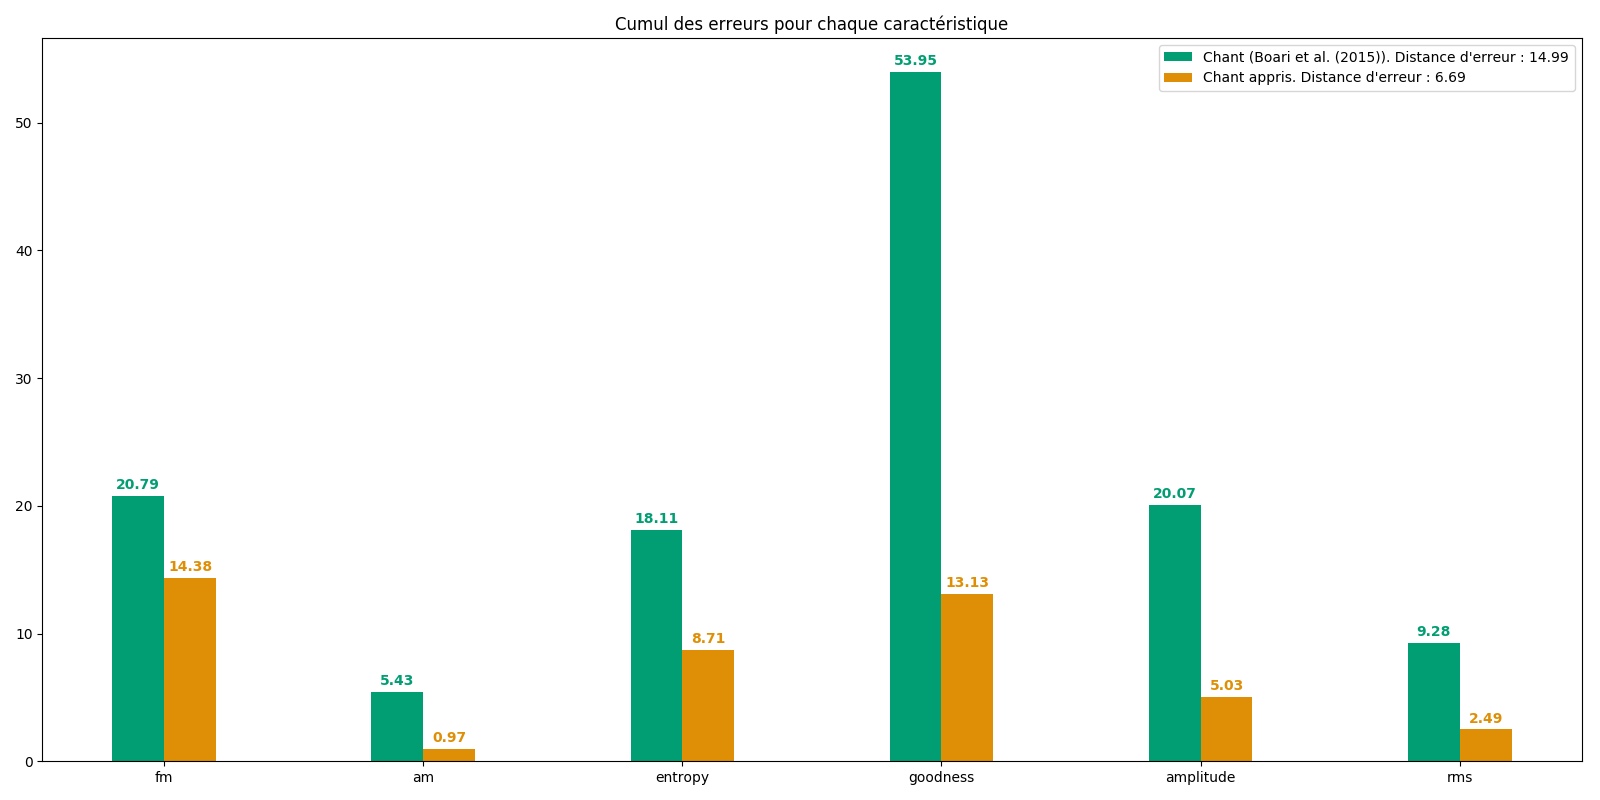

['fm', 'am', 'entropy', 'goodness', 'amplitude', 'rms']


In [28]:
# Code inspired from cmp_2_sim.py, the end of plot_fig function
color_synth = "C2"
color_song = "C1"
    
amp, th = carac_to_calculate_err_of_synth(synth_song,
                                          tfeat["amplitude"])

print("threshold:", th)

mtutor = bsa_measure(tutor, bsa.SR, run_param['coefs'], tfeat)
msynth = bsa_measure(synth_song, bsa.SR, run_param['coefs'], tfeat)
msong = bsa_measure(song, bsa.SR, run_param['coefs'], tfeat)

err_feat_vect = err_per_feat(mtutor, msong)
err_feat_vect_synth = err_per_feat(mtutor[amp > th],
                                   msynth[amp > th])

print("err_feat_vect: ", err_feat_vect)

# Ignore Pitch: 5 is the Pitch index in the fnames list in bsa_measure
err_feat_vect = np.delete(err_feat_vect, 5)
err_feat_vect_synth = np.delete(err_feat_vect_synth, 5)

x = np.arange(0,len(err_feat_vect))
fig = plt.figure(figsize=(fig_width,8))
ax = fig.gca()
synth_score = round(score, 2)
song_score = round(best_score, 2)
synth_label = "Chant (Boari et al. (2015)). Distance d'erreur : {}".format(synth_score)
song_label = "Chant appris. Distance d'erreur : {}".format(song_score)
plt.bar(x - 0.1, err_feat_vect_synth,
        width=0.2, align='center',
        label=synth_label, color=color_synth)
plt.bar(x + 0.1, err_feat_vect,
        width=0.2, align='center',
        label=song_label, color=color_song)
xlabels = [fnames[i] for i in range(len(fnames)) if fnames[i] != "pitch"]  # Ignore pitch
print(xlabels)
plt.xticks(x, xlabels)
# plt.xticks(x, fnames)
shift = np.max(np.concatenate((err_feat_vect_synth,
                               err_feat_vect))) / 100
for index in x:
    v_synth = err_feat_vect_synth[index]
    v_song = err_feat_vect[index]
    ax.text(index - 0.1, v_synth + shift,
            str(round(v_synth, 2)),
            color=color_synth, ha="center", fontweight='bold')
    ax.text(index + 0.1, v_song + shift,
            str(round(v_song, 2)),
            color=color_song, ha="center", fontweight='bold')
plt.legend()
plt.title("Cumul des erreurs pour chaque caractéristique")
plt.tight_layout()
plt.show()

Verification of the good calculation of the errors

In [29]:
print(np.sum(amp > th))
print(len(amp))
print(np.sqrt(np.sum(err_feat_vect_synth)) / np.sum(amp > th) * len(amp))
print(np.sqrt(np.sum(err_feat_vect)))

358
475
14.989055730662681
6.686594607321918


# Percentage night change

/home/gnouveau/.virtualenvs/birdsong/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


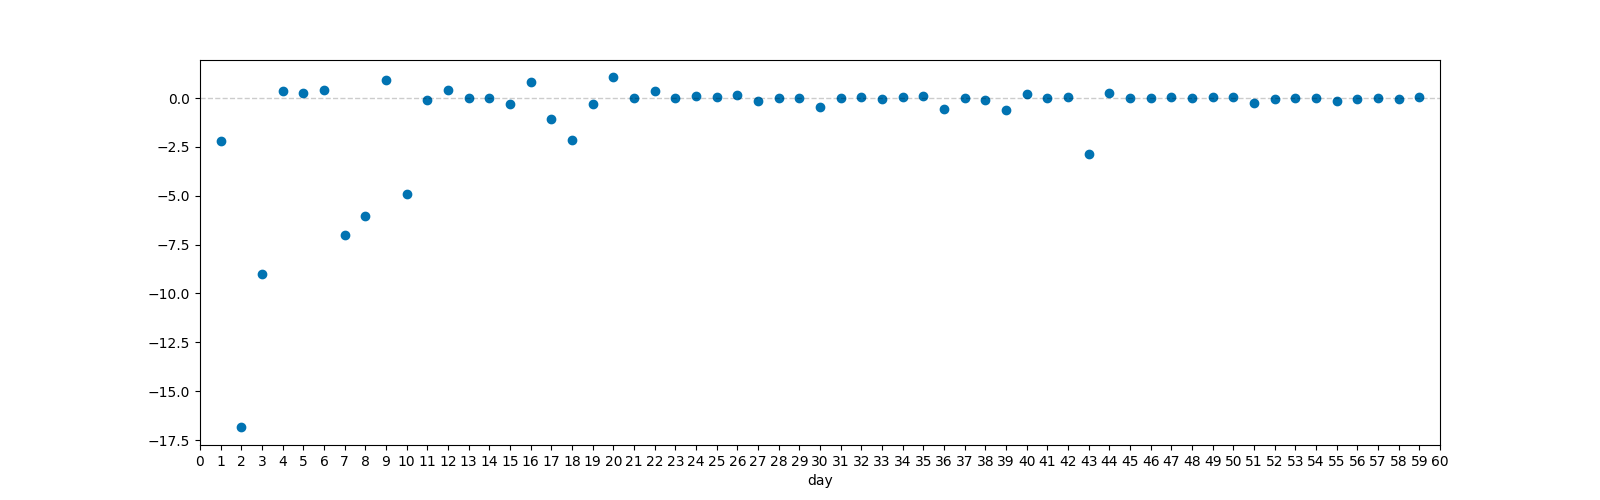

In [30]:
nights_errors = []

for i_after_night in range(2, len(rd), 2):
    # min is better than mean...
    beg = np.min(rd['scores'].iloc[i_after_night - 1])
    end = np.min(rd['scores'].iloc[i_after_night])
    nights_errors.append((end - beg) / beg)

# Multiply by -1, so if its negative, its a degradation (increasing of the score is a degradation)
# Multiply by 100 to get percentage
nights_errors = -1 * 100 * np.asarray(nights_errors)

xmin = 1
xmax = run_param["days"]
xstep = 1
x = np.arange(xmin, xmax, xstep)
plt.figure(figsize=(fig_width,fig_height))
plt.plot(x, nights_errors, 'o')
plt.xlim(xmin-1, xmax)
plt.xticks(np.arange(xmin-1, xmax+1, xstep))
plt.xlabel("day")
plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, ls="--", label="zero")
plt.show()

# TEST

look specific moment (define day_index values)

In [31]:
# # plot the (alpha, beta) of songs at day_index + GTE
# for day_index in [6, 12]:
#     print("scores on day_index {}: {}".format(day_index, rd['scores'].iloc[day_index]))
#     i = 1
# #     for i in range(len(rd['songs'].iloc[day_index])):
#     plt.figure(figsize=(fig_width, fig_height))
#     ab_tmp = rd['songs'].iloc[day_index][i].gen_alphabeta()
#     # Allow to split the gesture on the alpha and beta plots
#     for start, g in rd['songs'].iloc[day_index][i].gestures:
#         ab_tmp[start] = np.nan
#     plt.plot(ab_tmp[:, 0], label="alpha")
#     plt.plot(ab_tmp[:, 1], label="beta")
#     plt.xlim((0, ab_tmp.shape[0]))
#     for gesture in rd['songs'].iloc[day_index][i].gestures:
#         start = gesture[0]
#         plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
#     plt.title("song model #{} day index {}".format(i, day_index))
#     plt.legend()
# plt.show()

In [32]:
# # Code inspired from cmp_2_sim.py, the end of plot_fig function
# color_synth = "C2"
# color_song = "C1"
    
# amp, th = carac_to_calculate_err_of_synth(synth_song,
#                                           tfeat["amplitude"])

# print("threshold:", th)

# song = rd['songs'].iloc[6][1].gen_sound()
# best_score = rd['scores'].iloc[6][1]

# mtutor = bsa_measure(tutor, bsa.SR, run_param['coefs'], tfeat)
# msynth = bsa_measure(synth_song, bsa.SR, run_param['coefs'], tfeat)
# msong = bsa_measure(song, bsa.SR, run_param['coefs'], tfeat)

# err_feat_vect = err_per_feat(mtutor, msong)
# err_feat_vect_synth = err_per_feat(mtutor[amp > th],
#                                    msynth[amp > th])

# x = np.arange(0,len(err_feat_vect))
# fig = plt.figure(figsize=(fig_width,8))
# ax = fig.gca()
# synth_score = round(score, 2)
# song_score = round(best_score, 2)
# synth_label = "synth ({})".format(synth_score)
# song_label = "song ({})".format(song_score)
# plt.bar(x - 0.1, err_feat_vect_synth,
#         width=0.2, align='center',
#         label=synth_label, color=color_synth)
# plt.bar(x + 0.1, err_feat_vect,
#         width=0.2, align='center',
#         label=song_label, color=color_song)
# plt.xticks(x, fnames)
# shift = np.max(np.concatenate((err_feat_vect_synth,
#                                err_feat_vect))) / 100
# for index in x:
#     v_synth = err_feat_vect_synth[index]
#     v_song = err_feat_vect[index]
#     ax.text(index - 0.1, v_synth + shift,
#             str(round(v_synth, 2)),
#             color=color_synth, ha="center", fontweight='bold')
#     ax.text(index + 0.1, v_song + shift,
#             str(round(v_song, 2)),
#             color=color_song, ha="center", fontweight='bold')
# plt.legend()
# plt.title("Errors")
# plt.show()

# #############################################################################################################

# sfeat = bsa.all_song_features(song, bsa.SR,
#                               freq_range=bsa.FREQ_RANGE,
#                               fft_step=bsa.FFT_STEP,
#                               fft_size=bsa.FFT_SIZE)
# song_feat = bsa.rescaling_with_tutor_values(tfeat, sfeat)

# plt.figure(figsize=(fig_width, fig_height))
# plt.plot(tutor_feat['amplitude'], label="tutor")
# plt.plot(song_feat['amplitude'], alpha=0.6, label="song")
# plot_gesture_starts(g_starts, scale=40)
# plt.xlim(0, len(tutor_feat['amplitude']))
# plt.legend()
# plt.title('amplitude')
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.show()

# #############################################################################################################

# plt.figure(figsize=(fig_width, fig_height))
# plt.plot(song)
# plt.xlim(0, len(song))
# plt.show()

In [33]:
# # Code inspired from cmp_2_sim.py, the end of plot_fig function
# color_synth = "C2"
# color_song = "C1"
    
# amp, th = carac_to_calculate_err_of_synth(synth_song,
#                                           tfeat["amplitude"])

# print("threshold:", th)

# song = rd['songs'].iloc[12][1].gen_sound()
# best_score = rd['scores'].iloc[12][1]

# mtutor = bsa_measure(tutor, bsa.SR, run_param['coefs'], tfeat)
# msynth = bsa_measure(synth_song, bsa.SR, run_param['coefs'], tfeat)
# msong = bsa_measure(song, bsa.SR, run_param['coefs'], tfeat)

# err_feat_vect = err_per_feat(mtutor, msong)
# err_feat_vect_synth = err_per_feat(mtutor[amp > th],
#                                    msynth[amp > th])

# x = np.arange(0,len(err_feat_vect))
# fig = plt.figure(figsize=(fig_width,8))
# ax = fig.gca()
# synth_score = round(score, 2)
# song_score = round(best_score, 2)
# synth_label = "synth ({})".format(synth_score)
# song_label = "song ({})".format(song_score)
# plt.bar(x - 0.1, err_feat_vect_synth,
#         width=0.2, align='center',
#         label=synth_label, color=color_synth)
# plt.bar(x + 0.1, err_feat_vect,
#         width=0.2, align='center',
#         label=song_label, color=color_song)
# plt.xticks(x, fnames)
# shift = np.max(np.concatenate((err_feat_vect_synth,
#                                err_feat_vect))) / 100
# for index in x:
#     v_synth = err_feat_vect_synth[index]
#     v_song = err_feat_vect[index]
#     ax.text(index - 0.1, v_synth + shift,
#             str(round(v_synth, 2)),
#             color=color_synth, ha="center", fontweight='bold')
#     ax.text(index + 0.1, v_song + shift,
#             str(round(v_song, 2)),
#             color=color_song, ha="center", fontweight='bold')
# plt.legend()
# plt.title("Errors")
# plt.show()
# #############################################################################################################
# sfeat = bsa.all_song_features(song, bsa.SR,
#                               freq_range=bsa.FREQ_RANGE,
#                               fft_step=bsa.FFT_STEP,
#                               fft_size=bsa.FFT_SIZE)
# song_feat = bsa.rescaling_with_tutor_values(tfeat, sfeat)

# plt.figure(figsize=(fig_width, fig_height))
# plt.plot(tutor_feat['amplitude'], label="tutor")
# plt.plot(song_feat['amplitude'], alpha=0.6, label="song")
# plot_gesture_starts(g_starts, scale=40)
# plt.xlim(0, len(tutor_feat['amplitude']))
# plt.legend()
# plt.title('amplitude')
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.show()

# #############################################################################################################

# plt.figure(figsize=(fig_width, fig_height))
# plt.plot(song)
# plt.xlim(0, len(song))
# plt.show()